# 자전거 대여 수요 예측
- 캐글의 자전거 대여 수요(Bike Sharing Demand) 데이터를 사용한다
- 출처:https://www.kaggle.com/c/bike-sharing-demand/data


## 데이터 설명
#### 2011년 1월부터 2012년 12월까지 날짜/시간,기온,습도,풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재된 데이터

## 주요변수 설명
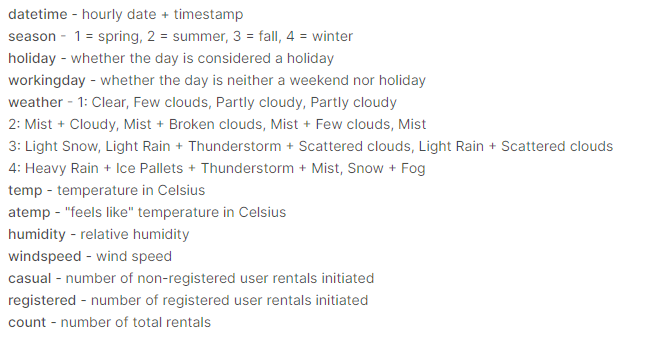

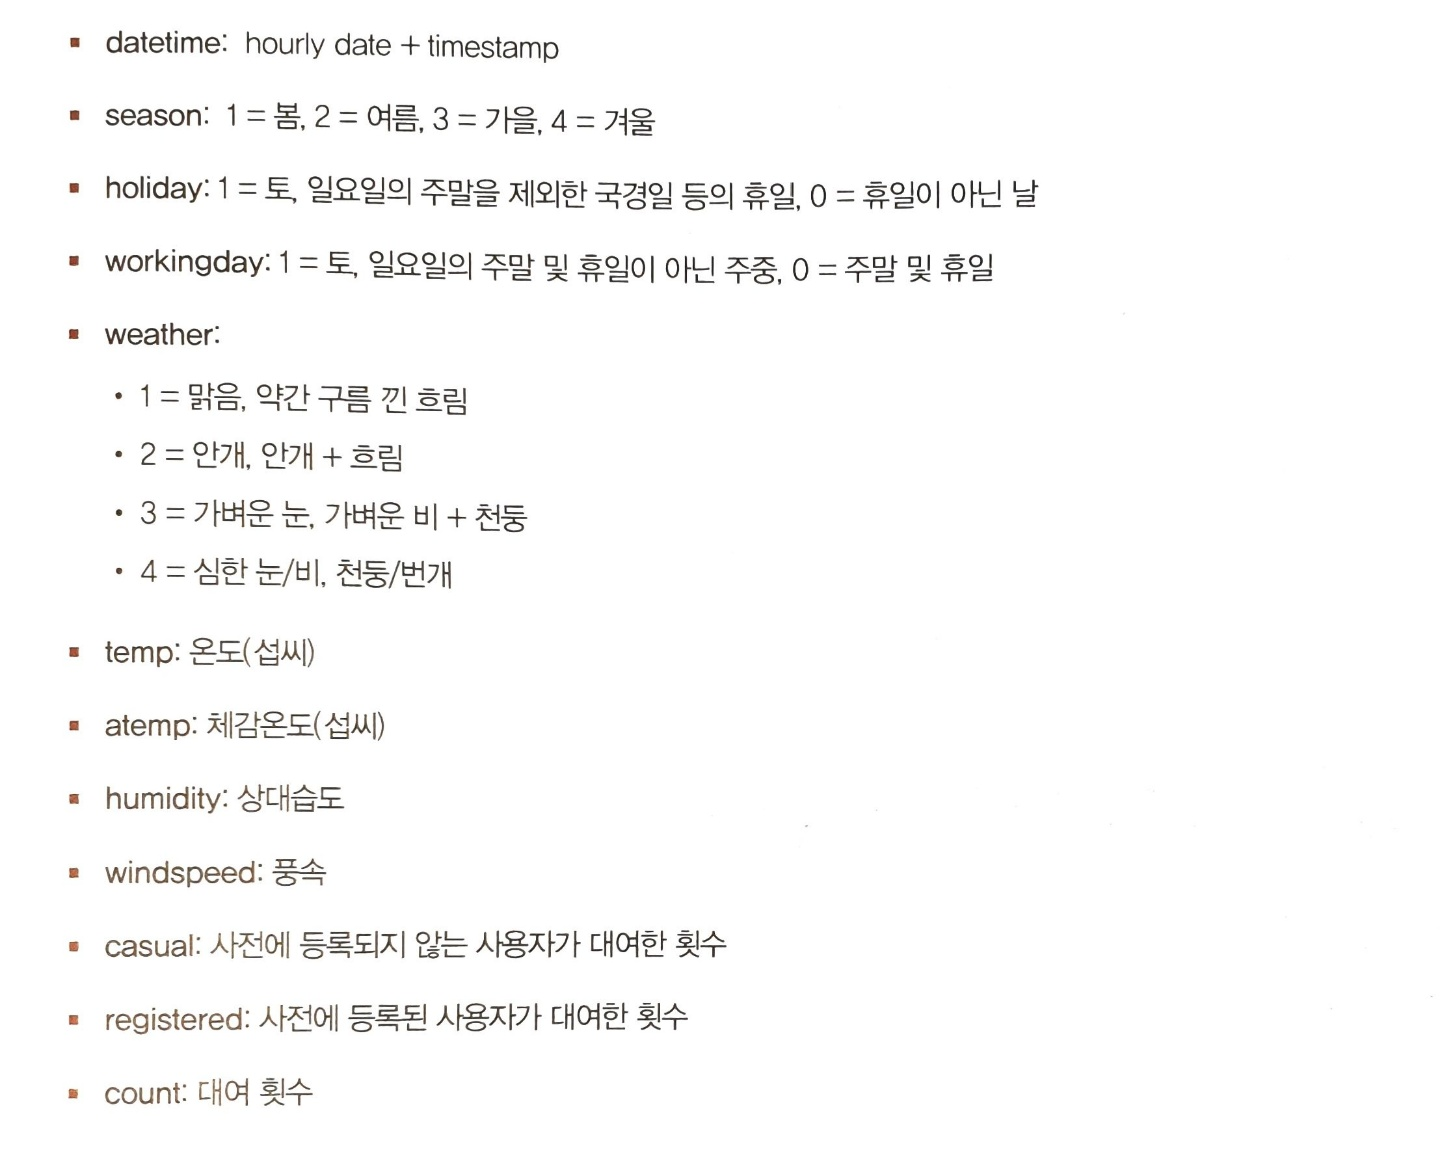

## 데이터 탐색 및 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


- 10886개의 데이터가 12개의 컬럼으로 이루어져있다.

In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- Null 값은 존재하지 않는다
- 대부분이 숫자형 (int,float)이다
- datetime만 object 형이다  -> 가공 필요


### 문자열인 datetime의 가공
- datetime 타입으로 변경하여 가공
- apply(pd.to_datetime) 메서드를 사용하여 년, 월, 일, 시간 컬럼을 추출

In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x : x.year)
bike_df['month']=bike_df.datetime.apply(lambda x : x.month)
bike_df['day']=bike_df.datetime.apply(lambda x : x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
# 년,월,일,시간 변수가 추가되었으므로 datetime 변수는 삭제
# 또한 casual +registered = count 이므로 목적에 어긋남 -> 삭제
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

In [5]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


## 평가 기준 함수 생성
- 캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)
- 즉, 오류 값의 로그에 대한 RMSE이다.
- 사이킷런에 존재하지 않으므로 직접 함수를 생성한다

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## 1차 분석
### 데이터에 따로 변환을 주지않고 회귀분석을 실행하고 성능을 살펴본다

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [9]:
y_train.mean()

190.3498687664042

### 평균 대여수가 190이란걸 고려하면 MAE가 105.924라는 것은 너무 큰 에러임을 생각할 수 있다.

## Target값의 분포를 한번 살펴본다

<AxesSubplot:>

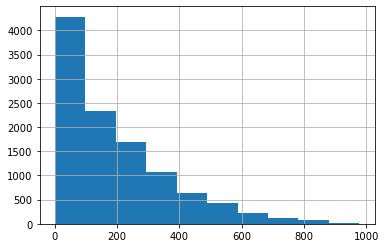

In [10]:
y_target.hist()

- 정규분포가 아니라 치우친 형태의 데이터 임을 알 수 있다.
- 로그변환을 적용해본다

<AxesSubplot:>

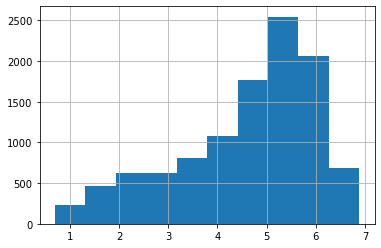

In [11]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

- 정규분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상되었다.
- 이를 이요해 다시 학습한 후 평가를 수행

In [12]:
# 타깃 컬럼인 count 값을 log1p로 로그 변환
y_target_log=np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- RMSLE는 감소했지만 ,RMSE와 MAE는 오히려 증가하였다. 
- 이유를 살펴보기 위해 회귀계수를 살펴본다

<AxesSubplot:>

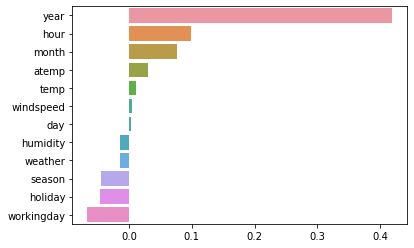

In [14]:
coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

- Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가짐을 알 수 있다. 
- 하지만 Year는 2011, 2012 두가지 값으로 구성되어있기에 자전거 대여 횟수에 크게 영향을 준다는 것이 합리적이지 않다
- year 변수가 카테고리형이지만 숫자로 들어가있어 회귀식에서 잘못 인지했을 가능성이 있다. 
- 이를 원-핫 인코딩 적용해준다
- hour, month 등의 변수 역시 원-핫 인코딩 해준다

In [15]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

### 변환된 데이터 세트를 기반으로 LinearRegression, Ridge, Lasso 모두 학습해 평가한다

In [16]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

In [17]:
# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

In [22]:
# 훈련
lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train,y_train)
lasso_reg.fit(X_train,y_train)

# 예측
pred_lr = lr_reg.predict(X_test)
pred_ridge = ridge_reg.predict(X_test)
pred_lasso = lasso_reg.predict(X_test)

# 평가 - log에서 원래 형태로 변환 필요
y_test_exp = np.expm1(y_test)

pred_lr_exp = np.expm1(pred_lr)
pred_ridge_exp = np.expm1(pred_ridge)
pred_lasso_exp = np.expm1(pred_lasso)

print('lr 평가:')
print(evaluate_regr(y_test_exp ,pred_lr_exp))
print('ridge 평가:')
print(evaluate_regr(y_test_exp ,pred_ridge_exp))
print('lasso 평가:')
print(evaluate_regr(y_test_exp ,pred_lasso_exp))

lr 평가:
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
None
ridge 평가:
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
None
lasso 평가:
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803
None


### 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다

### 다시, 회귀계수들을 살펴보면 변수들의 관계를 고려해본다
- 원-핫 인코딩으로 변수가 너무 많아 회귀계수 상위20개의 변수만 추출

<AxesSubplot:>

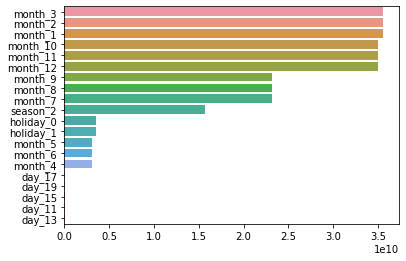

In [23]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

- 월, 주말&주중, 시간대 등 자전거를 타는 데 필요한 피처의 회귀 계수가 높아짐을 확인
- 선형회귀수행 시에는 피처를 인코딩하는 방식에 따라 큰 성향을 미친다

## 회귀트리 실습
- RF(RandomForest), GBM, LightGBM 을 순차적으로 성능 평가해본다

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

In [28]:
# 훈련
rf_reg.fit(X_train, y_train)
gbm_reg.fit(X_train,y_train)
lgbm_reg.fit(X_train,y_train)

LGBMRegressor(n_estimators=500)

In [30]:
# 예측
pred_rf = rf_reg.predict(X_test)
pred_gbm = gbm_reg.predict(X_test)
pred_lgbm = lgbm_reg.predict(X_test)

In [31]:
# 평가 - log에서 원래 형태로 변환 필요
y_test_exp = np.expm1(y_test)

pred_rf_exp = np.expm1(pred_rf)
pred_gbm_exp = np.expm1(pred_gbm)
pred_lgbm_exp = np.expm1(pred_lgbm)

print('rf 평가:')
print(evaluate_regr(y_test_exp ,pred_rf_exp))
print('gbm 평가:')
print(evaluate_regr(y_test_exp ,pred_gbm_exp))
print('lgbm 평가:')
print(evaluate_regr(y_test_exp ,pred_lgbm_exp))


rf 평가:
RMSLE: 0.354, RMSE: 50.202, MAE: 31.096
None
gbm 평가:
RMSLE: 0.330, RMSE: 53.344, MAE: 32.745
None
lgbm 평가:
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
None


## 성능이 상당히 개선되었다.
### 하지만, 이게 선형회귀보다 회귀트리가 좋다는 의미는 아님
### 데이터의 구조, 인코딩 방식에 따라 성능이 다르면 알맞는 모델이 있음을 인지하는 것이 중요